## Desarrollo de TFG: Análisis y predicción de accidentes de tráfico en california aplicando técnicas de predicción de series temporales.

**Convocatoria: 10 de junio de 2024** <br>
**Alumno: Jorge Tesch Torres** <br>
**Tutora: María del Mar Angulo Martinez** <br>
**Grado: Matemática Computacional** <br>

## Importación de Librerías

In [56]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasRegressor

from kan import KAN, create_dataset

import torch

import logging
import sys

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="whitegrid")

## 1. Tratamiento Inicial de los Datos

In [57]:
df = pd.read_csv('US_Accidents_March23.csv')

df = df[df['State'] == "CA"]

cols_relevant = [
    'Severity', 'Start_Time', 'End_Time', 'Distance(mi)', 
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)', 'Wind_Direction', 
    'Precipitation(in)', 'Sunrise_Sunset'
]

df = df[cols_relevant]
df = df.dropna()

df['Distance(m)'] = (df['Distance(mi)'] * 1.60934 * 1000).round(2)
df['Temperature(C)'] = ((df['Temperature(F)'] - 32) * 5.0/9.0).round(2)
df['Pressure(hPa)'] = (df['Pressure(in)'] * 33.8639).round(2)
df['Visibility(m)'] = (df['Visibility(mi)'] * 1.60934 * 1000).round(2)
df['Wind_Speed(km/h)'] = (df['Wind_Speed(mph)'] * 1.60934).round(2)
df['Precipitation(mm)'] = (df['Precipitation(in)'] * 25.4).round(2)
df['Start_Time'] = pd.to_datetime(df['Start_Time'].str.split('.').str[0], format='%Y-%m-%d %H:%M:%S')
df['End_Time'] = pd.to_datetime(df['End_Time'].str.split('.').str[0], format='%Y-%m-%d %H:%M:%S')
df['Duration(min)'] = ((df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60).astype(np.int64)

cols_final = [
    'Severity', 'Start_Time', 'Duration(min)', 'Distance(m)', 
    'Temperature(C)', 'Humidity(%)', 'Pressure(hPa)', 
    'Visibility(m)', 'Wind_Speed(km/h)', 'Wind_Direction', 
    'Precipitation(mm)', 'Sunrise_Sunset'
]

df = df[cols_final]

df.sample(5)

,Severity,Start_Time,Duration(min),Distance(m),Temperature(C),Humidity(%),Pressure(hPa),Visibility(m),Wind_Speed(km/h),Wind_Direction,Precipitation(mm),Sunrise_Sunset
4946069,2,2022-12-18 10:44:00,77,1404.95,16.11,23.00,1009.48,16093.40,4.83,E,0.00,Day
4139479,2,2023-02-07 07:12:00,214,6812.34,3.89,87.00,1026.75,16093.40,0.00,CALM,0.00,Day
4444985,2,2022-07-07 05:00:30,240,1805.68,15.00,93.00,994.92,16093.40,0.00,CALM,0.00,Night
7370800,2,2019-09-15 19:04:00,94,0.00,22.78,55.00,1007.11,16093.40,27.36,SW,0.00,Day
776557,2,2021-12-09 08:47:34,59,482.80,10.00,71.00,1011.51,16093.40,9.66,VAR,0.00,Day


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1148104 entries, 958 to 7728393
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Severity           1148104 non-null  int64         
 1   Start_Time         1148104 non-null  datetime64[ns]
 2   Duration(min)      1148104 non-null  int64         
 3   Distance(m)        1148104 non-null  float64       
 4   Temperature(C)     1148104 non-null  float64       
 5   Humidity(%)        1148104 non-null  float64       
 6   Pressure(hPa)      1148104 non-null  float64       
 7   Visibility(m)      1148104 non-null  float64       
 8   Wind_Speed(km/h)   1148104 non-null  float64       
 9   Wind_Direction     1148104 non-null  object        
 10  Precipitation(mm)  1148104 non-null  float64       
 11  Sunrise_Sunset     1148104 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 113.9+ MB


## 2. Análisis Descriptivo y Exploratorio de los Datos

In [59]:
df.describe()

,Severity,Start_Time,Duration(min),Distance(m),Temperature(C),Humidity(%),Pressure(hPa),Visibility(m),Wind_Speed(km/h),Precipitation(mm)
count,1148104.00,1148104,1148104.00,1148104.00,1148104.00,1148104.00,1148104.00,1148104.00,1148104.00,1148104.00
mean,2.09,2021-05-04 11:21:37.403329792,126.22,977.53,17.30,58.80,999.51,14497.04,9.85,0.10
min,1.00,2016-03-23 05:03:47,3.00,0.00,-22.22,1.00,565.87,0.00,0.00,0.00
25%,2.00,2020-05-14 03:51:30,46.00,0.00,12.22,39.00,995.94,16093.40,0.00,0.00
50%,2.00,2021-06-29 06:10:30,81.00,136.79,16.67,62.00,1008.81,16093.40,9.66,0.00
75%,2.00,2022-05-02 10:31:00,133.00,952.73,22.22,79.00,1013.89,16093.40,14.48,0.00
max,4.00,2023-03-31 23:25:30,525599.00,122116.71,52.78,100.00,1977.31,160934.00,1749.35,264.16
std,0.33,NaN,1499.21,2424.34,7.70,24.56,29.25,4340.85,8.80,0.73


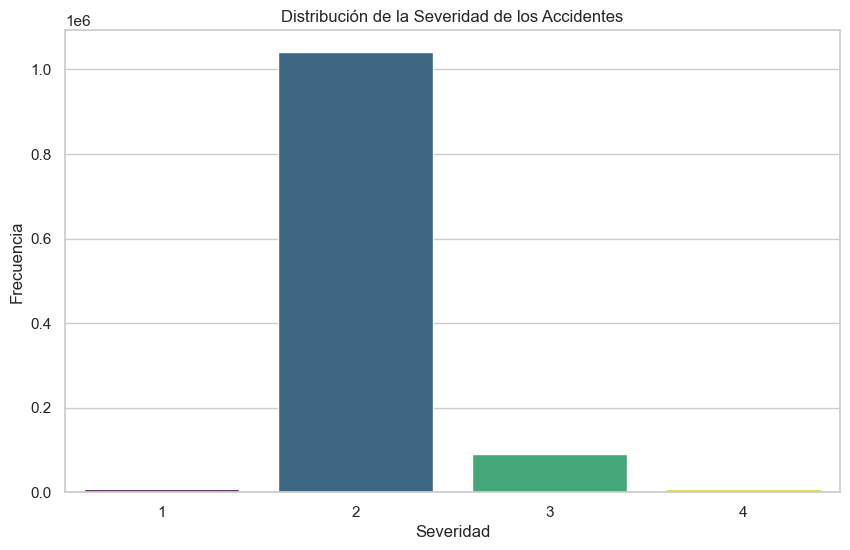

In [60]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Severity', data=df, hue='Severity', palette='viridis', legend=False)
plt.title('Distribución de la Severidad de los Accidentes')
plt.xlabel('Severidad')
plt.ylabel('Frecuencia')
plt.show()

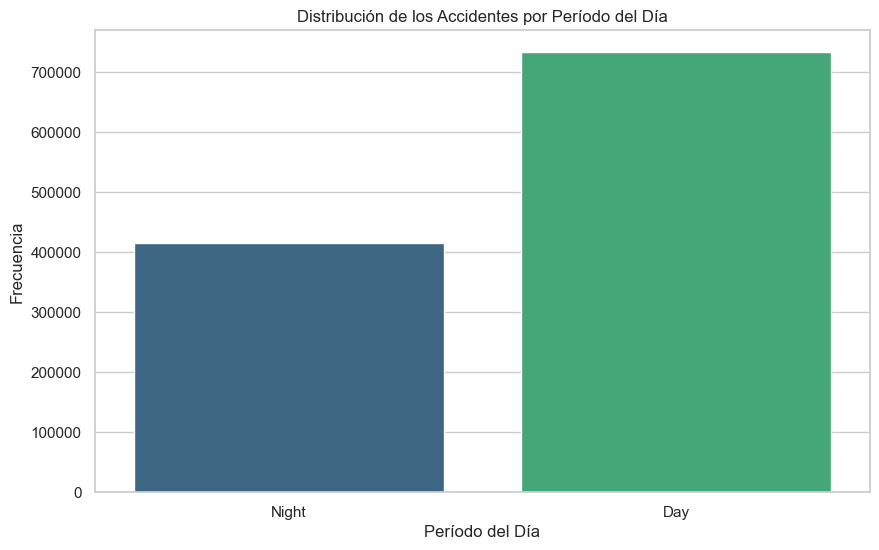

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sunrise_Sunset', data=df, hue='Sunrise_Sunset', palette='viridis', dodge=False, legend=False)
plt.title('Distribución de los Accidentes por Período del Día')
plt.xlabel('Período del Día')
plt.ylabel('Frecuencia')
plt.show()

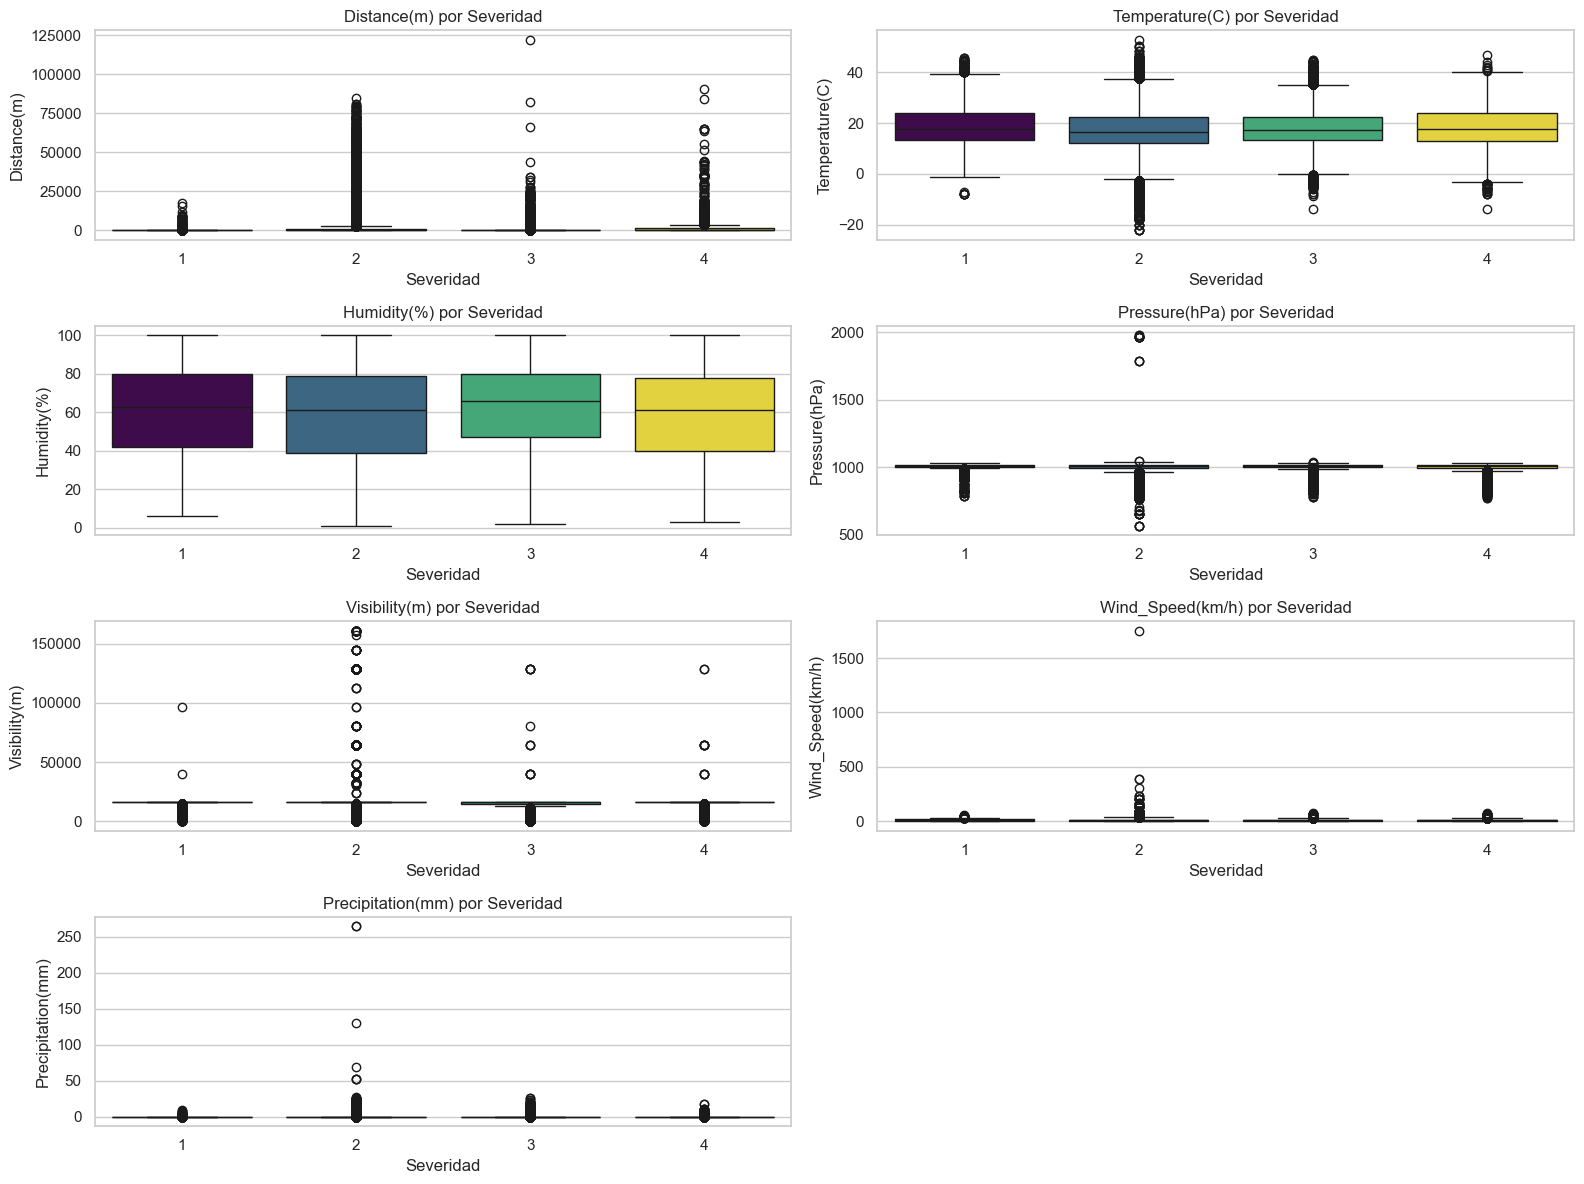

In [62]:
numeric_vars = ['Distance(m)', 'Temperature(C)', 'Humidity(%)', 'Pressure(hPa)', 'Visibility(m)', 'Wind_Speed(km/h)', 'Precipitation(mm)']

plt.figure(figsize=(16, 12))
for i, var in enumerate(numeric_vars, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='Severity', y=var, data=df, hue='Severity', palette='viridis', dodge=False, legend=False)
    plt.title(f'{var} por Severidad')
    plt.xlabel('Severidad')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

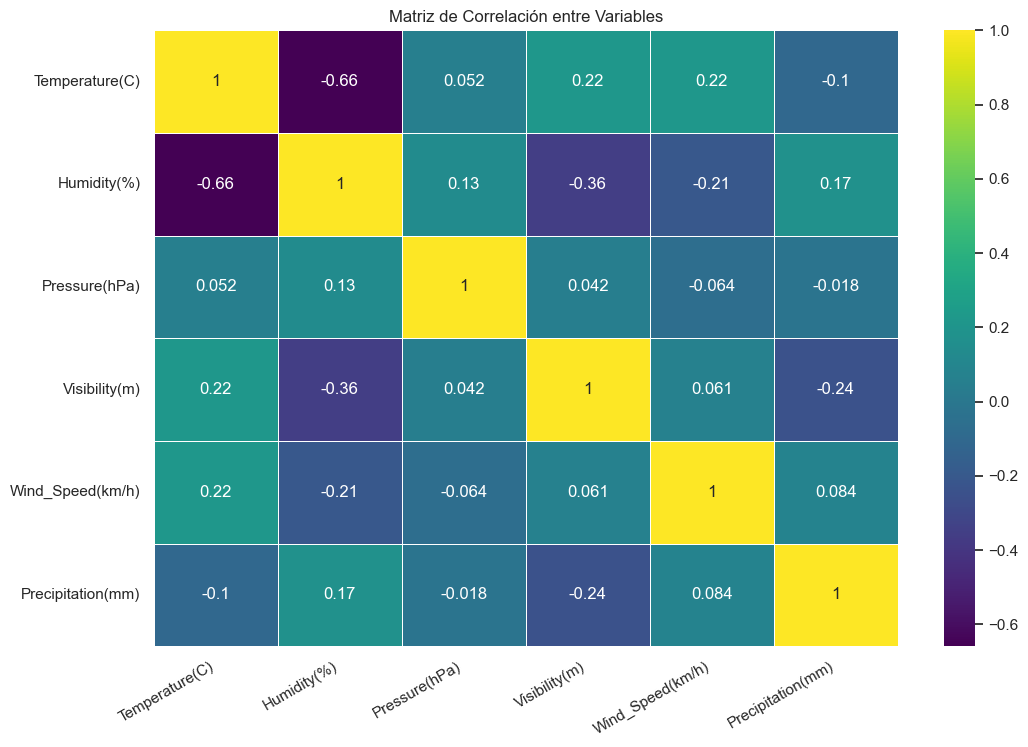

In [63]:
exog_df = df[['Temperature(C)', 'Humidity(%)', 'Pressure(hPa)', 'Visibility(m)', 'Wind_Speed(km/h)', 'Precipitation(mm)']]

plt.figure(figsize=(12, 8))
correlation_matrix = exog_df.corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, ha='right')
plt.title('Matriz de Correlación entre Variables')
plt.show()

## 3. Análisis de la Serie Temporal

### 3.1. Análisis de la Serie Temporal de Recuento Diario de Accidentes

In [64]:
cols_ts = [
    'Severity', 'Start_Time', 'Temperature(C)', 'Humidity(%)', 
    'Pressure(hPa)', 'Visibility(m)', 'Wind_Speed(km/h)', 
    'Precipitation(mm)'
]

df = df[cols_ts]

df['Accident_Count'] = 1

df = df.resample('D', on='Start_Time').agg({
    'Severity': 'mean',
    'Temperature(C)': 'mean',
    'Humidity(%)': 'mean',
    'Pressure(hPa)': 'mean',
    'Visibility(m)': 'mean',
    'Wind_Speed(km/h)': 'mean',
    'Precipitation(mm)': 'mean',
    'Accident_Count': 'sum'
})

df = df[df.index >= '2020-01-01']
df['Accident_Count'] = df['Accident_Count'].replace(0, np.nan)
df['Accident_Count'] = df['Accident_Count'].interpolate(method='linear').round().astype(int)
df = df.interpolate(method='linear')

df.sample(5)

,Severity,Temperature(C),Humidity(%),Pressure(hPa),Visibility(m),Wind_Speed(km/h),Precipitation(mm),Accident_Count
Start_Time,,,,,,,,
2022-07-24,2.12,24.25,54.10,992.55,15189.05,10.94,0.00,783
2021-08-10,2.06,27.53,46.75,998.75,15005.17,11.18,0.00,796
2021-05-09,2.08,19.50,52.74,993.93,15479.97,11.87,0.00,446
2022-03-17,2.05,18.08,47.34,1002.75,15583.39,10.62,0.00,1319
2020-03-05,2.08,17.33,60.80,1004.79,14052.79,8.29,0.00,890


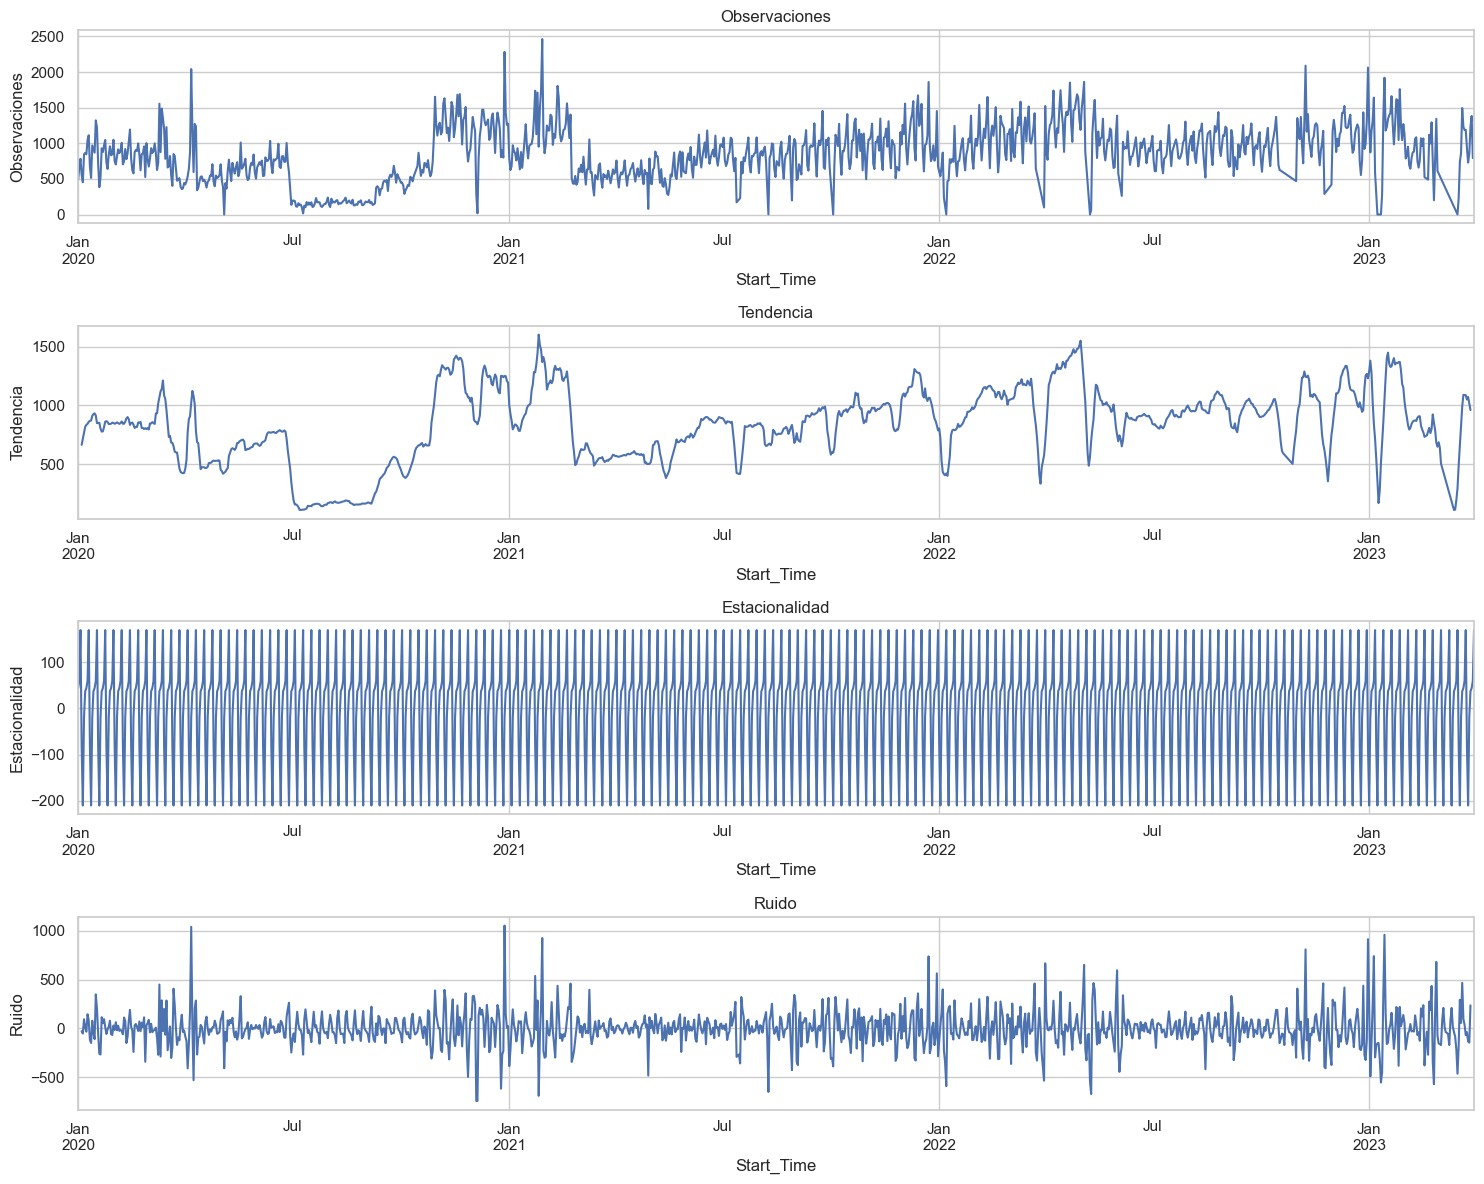

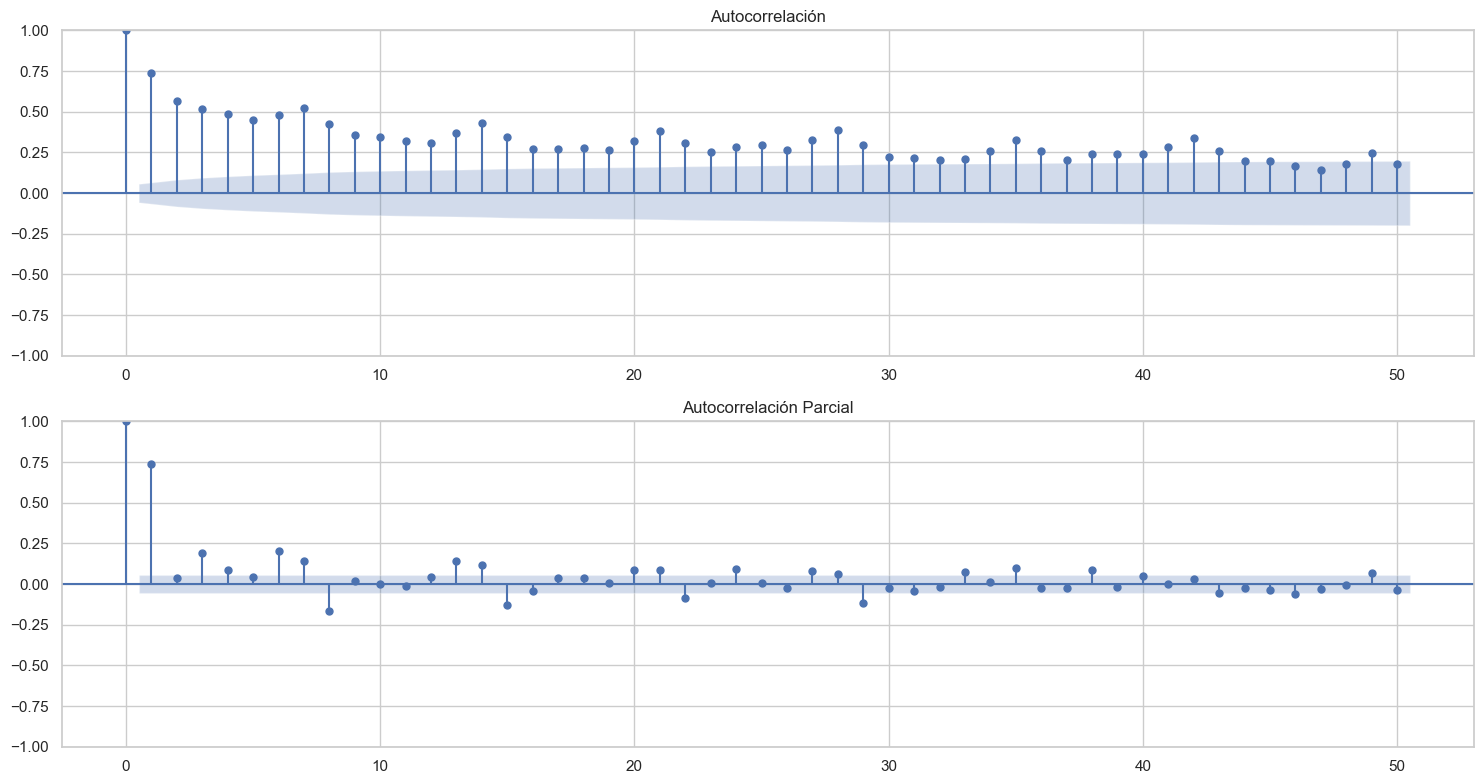

In [65]:
decomposition = seasonal_decompose(df['Accident_Count'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observaciones')
ax1.set_title('Observaciones')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Tendencia')
ax2.set_title('Tendencia')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Estacionalidad')
ax3.set_title('Estacionalidad')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Ruido')
ax4.set_title('Ruido')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(df['Accident_Count'], lags=50, ax=ax1)
plot_pacf(df['Accident_Count'], lags=50, ax=ax2)

ax1.set_title('Autocorrelación')
ax2.set_title('Autocorrelación Parcial')

plt.tight_layout()
plt.show()

### 3.2. Análisis de la Serie Temporal de Gravedad de Media de Accidentes Diarios

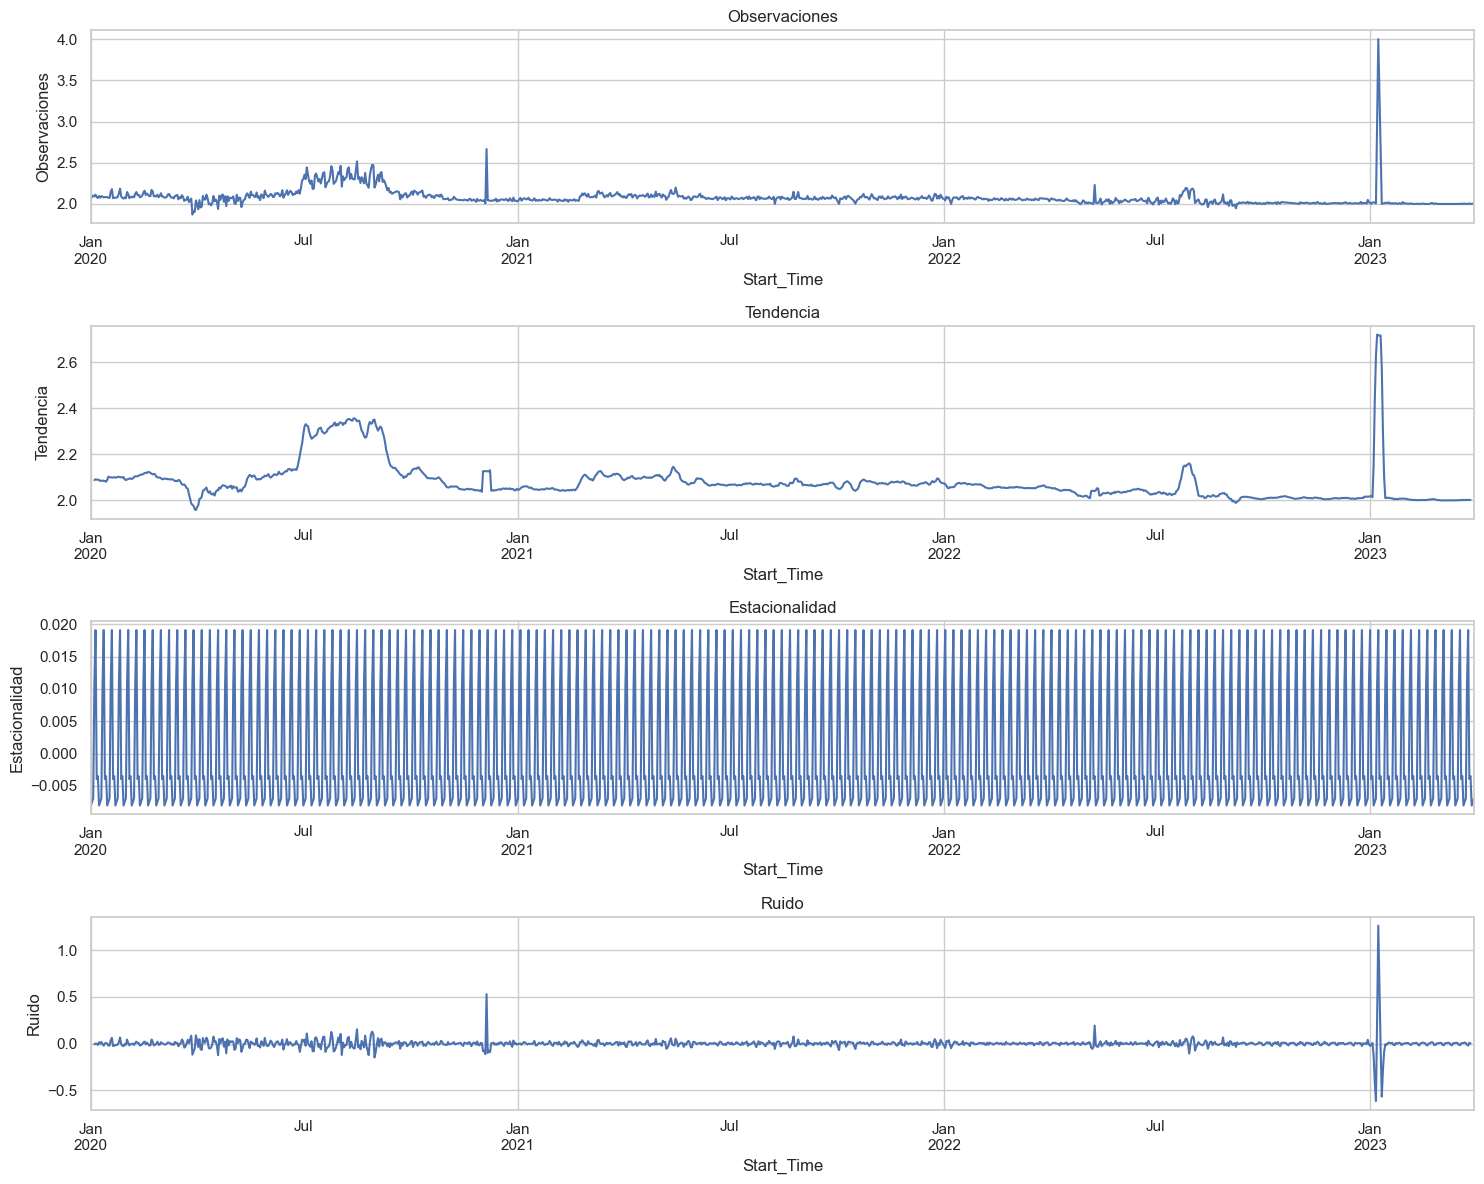

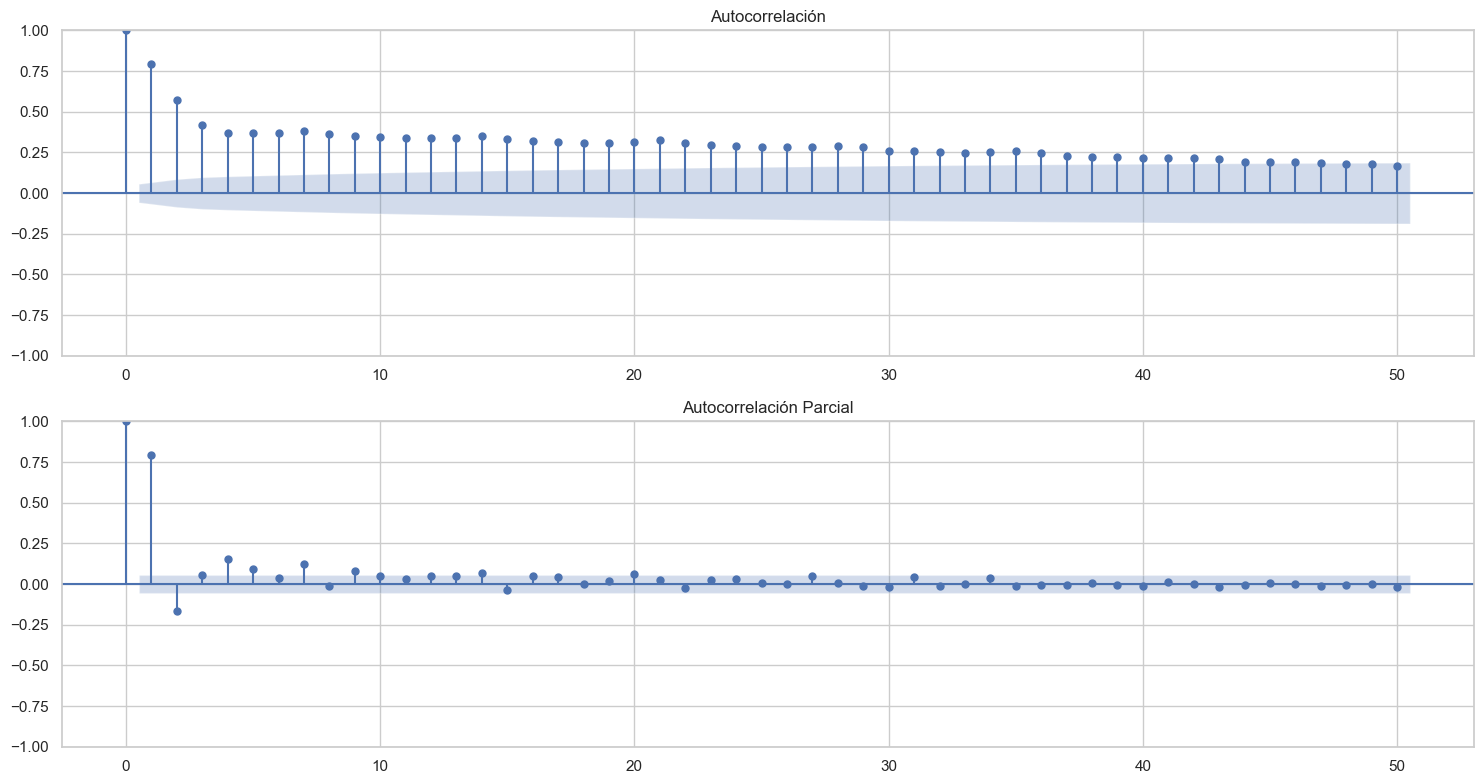

In [66]:
decomposition = seasonal_decompose(df['Severity'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observaciones')
ax1.set_title('Observaciones')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Tendencia')
ax2.set_title('Tendencia')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Estacionalidad')
ax3.set_title('Estacionalidad')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Ruido')
ax4.set_title('Ruido')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(df['Severity'], lags=50, ax=ax1)
plot_pacf(df['Severity'], lags=50, ax=ax2)

ax1.set_title('Autocorrelación')
ax2.set_title('Autocorrelación Parcial')

plt.tight_layout()
plt.show()

## 4. Predicción de Series Temporales

In [67]:
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, forecast)
    return mae, mse, rmse, r2

### 4.1. Predicción de Recuento de Accidentes Diarios

In [68]:
df_count = df.drop('Severity', axis=1)

#### Enfoque Clásico - Método de Medias Móviles

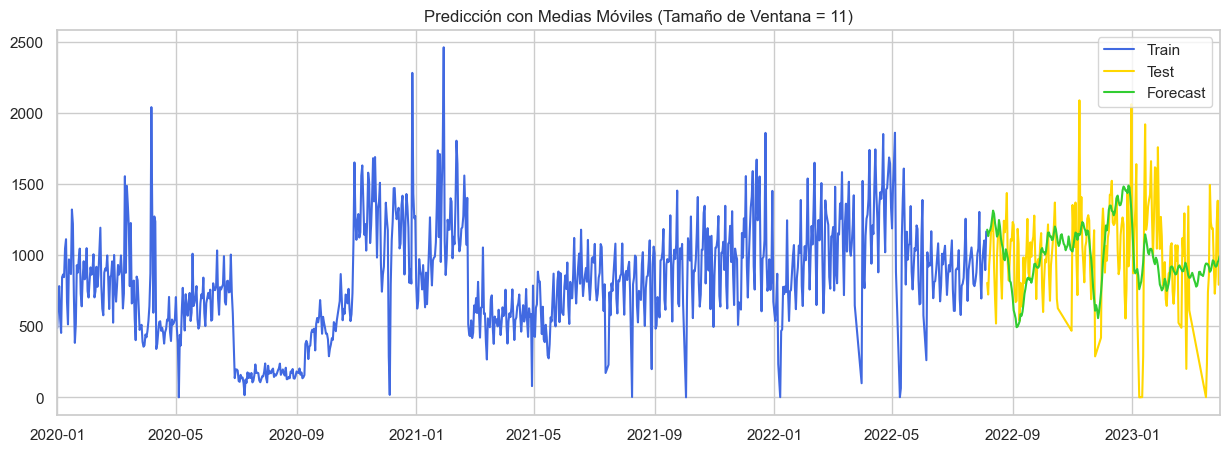

,MAE,MSE,RMSE,R2
Window_Size,,,,
1,363.56,232431.99,482.11,-0.55
2,360.05,215583.95,464.31,-0.44
3,362.34,211250.48,459.62,-0.41
4,355.97,202164.84,449.63,-0.35
5,344.78,191790.45,437.94,-0.28
6,336.34,182541.62,427.25,-0.22
7,323.52,170531.38,412.95,-0.14
8,310.31,157229.90,396.52,-0.05
9,303.62,147862.39,384.53,0.01


In [69]:
train_size = int(len(df_count) * 0.8)
train, test = df_count.iloc[:train_size], df_count.iloc[train_size:]

best_window_size = None
best_score = float('inf')
metrics_results = []

for window_size in range(1, 21):
    rolling_mean = train['Accident_Count'].rolling(window=window_size).mean()
    forecast = rolling_mean[-len(test):].values
    mae, mse, rmse, r2 = evaluate_forecast(test['Accident_Count'], forecast)
    metrics_results.append((window_size, mae, mse, rmse, r2))
    
    if rmse < best_score:
        best_score = rmse
        best_window_size = window_size

metrics_ma = [metrics for metrics in metrics_results if metrics[0] == best_window_size][0]
ma_mae, ma_mse, ma_rmse, ma_r2 = metrics_ma[1:5]

rolling_mean = train['Accident_Count'].rolling(window=best_window_size).mean()
test = test.copy()
test.loc[:, 'Forecast'] = rolling_mean[-len(test):].values

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Accident_Count'], label='Train', color="royalblue")
plt.plot(test.index, test['Accident_Count'], label='Test', color="gold")
plt.plot(test.index, test['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con Medias Móviles (Tamaño de Ventana = {best_window_size})')
plt.margins(x=0)
plt.show()

metrics_df = pd.DataFrame(metrics_results, columns=['Window_Size', 'MAE', 'MSE', 'RMSE', 'R2'])
metrics_df = metrics_df.set_index('Window_Size')
metrics_df

#### SARIMAX

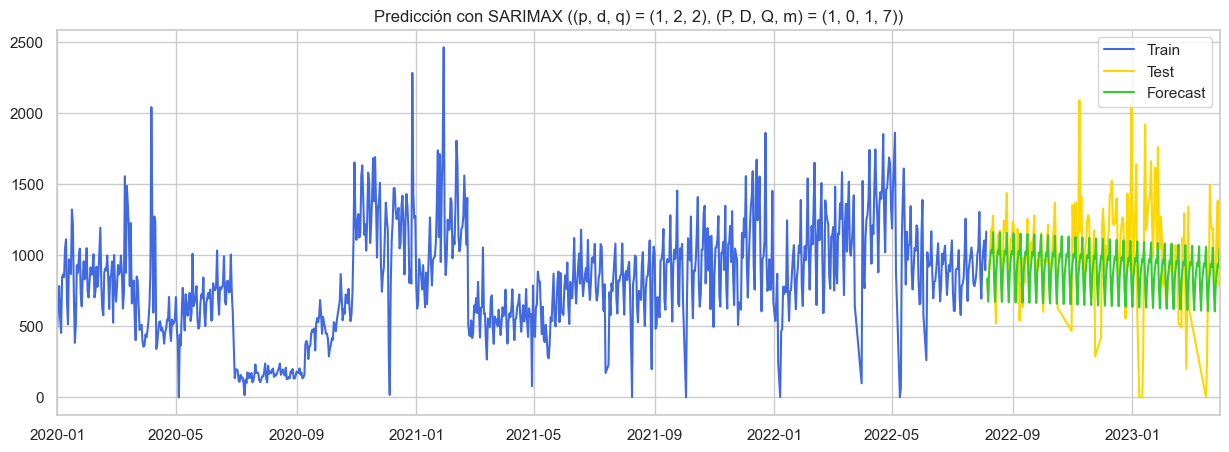

MAE       MSE   RMSE    R2
Order     Seasonal_Order                              
(0, 0, 0) (0, 0, 0, 7)   915.11 987023.11 993.49 -5.60
          (0, 0, 1, 7)   903.79 968238.68 983.99 -5.47
          (0, 1, 0, 7)   277.79 145459.93 381.39  0.03
          (0, 1, 1, 7)   276.53 141125.24 375.67  0.06
          (1, 0, 0, 7)   577.05 492520.87 701.80 -2.29
...                         ...       ...    ...   ...
(2, 2, 2) (0, 1, 1, 7)   272.45 140438.70 374.75  0.06
          (1, 0, 0, 7)   314.58 164477.84 405.56 -0.10
          (1, 0, 1, 7)   272.75 137462.04 370.76  0.08
          (1, 1, 0, 7)   279.04 138510.71 372.17  0.07
          (1, 1, 1, 7)   280.88 139044.32 372.89  0.07

[216 rows x 4 columns]

In [70]:
warnings.filterwarnings('ignore')

train_size = int(len(df_count) * 0.8)
train, test = df_count.iloc[:train_size], df_count.iloc[train_size:]

p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = [7]

pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], sp) for x in \
                list(product(seasonal_p, seasonal_d, seasonal_q)) for sp in seasonal_period]

best_score = float('inf')
best_pdq = None
best_seasonal_pdq = None
metrics_results = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train['Accident_Count'], order=param, seasonal_order=param_seasonal, \
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            forecast = results.get_forecast(steps=len(test)).predicted_mean
            mae, mse, rmse, r2 = evaluate_forecast(test['Accident_Count'], forecast)
            metrics_results.append((param, param_seasonal, mae, mse, rmse, r2))
            
            if rmse < best_score:
                best_score = rmse
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

metrics_sarimax = [metrics for metrics in metrics_results \
                   if metrics[0] == best_pdq and metrics[1] == best_seasonal_pdq][0]
sarimax_mae, sarimax_mse, sarimax_rmse, sarimax_r2 = metrics_sarimax[2:6]

best_model = SARIMAX(train['Accident_Count'], order=best_pdq, seasonal_order=best_seasonal_pdq, \
                     enforce_stationarity=False, enforce_invertibility=False)
sarimax_results = best_model.fit(disp=False)
test.loc[:, 'Forecast'] = sarimax_results.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Accident_Count'], label='Train', color="royalblue")
plt.plot(test.index, test['Accident_Count'], label='Test', color="gold")
plt.plot(test.index, test['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con SARIMAX ((p, d, q) = {best_pdq}, (P, D, Q, m) = {best_seasonal_pdq})')
plt.margins(x=0)
plt.show()

metrics_df = pd.DataFrame(metrics_results, columns=['Order', 'Seasonal_Order', 'MAE', 'MSE', 'RMSE', 'R2'])
metrics_df = metrics_df.set_index(['Order', 'Seasonal_Order'])
metrics_df

#### Prophet

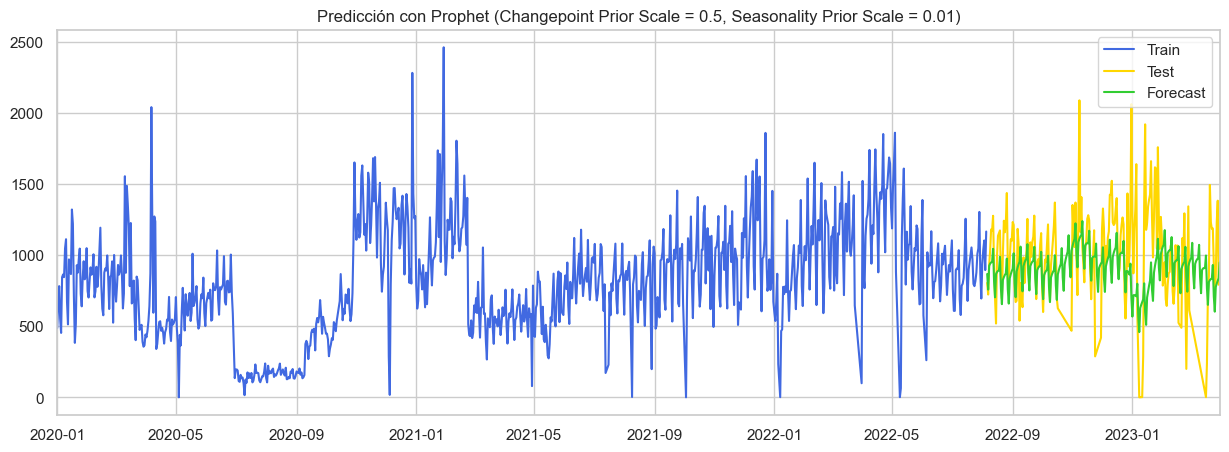

MAE       MSE   RMSE    R2
Changepoint_Prior_Scale Seasonality_Prior_Scale                              
0.01                    0.01                    356.75 218851.45 467.82 -0.46
                        0.10                    390.77 247566.39 497.56 -0.65
                        1.00                    390.05 246349.84 496.34 -0.65
                        10.00                   392.05 249253.05 499.25 -0.67
0.10                    0.01                    370.69 237108.34 486.94 -0.59
                        0.10                    625.39 577822.58 760.15 -2.86
                        1.00                    634.26 591919.94 769.36 -2.96
                        10.00                   629.50 584408.79 764.47 -2.91
0.50                    0.01                    292.37 144446.74 380.06  0.03
                        0.10                    503.59 415608.38 644.68 -1.78
                        1.00                    555.42 489282.35 699.49 -2.27
                        10.00                   552.82 485870.40 697.04 -2.25
1.00                    0.01                    291.10 147378.85 383.90  0.01
                        0.10                    630.58 600817.29 775.12 -3.02
                        1.00                    799.10 903184.68 950.36 -5.04
                        10.00                   785.33 877058.51 936.51 -4.86

In [71]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

df_prophet = df_count[['Accident_Count']].reset_index()
df_prophet.rename(columns={'Start_Time': 'ds', 'Accident_Count': 'y'}, inplace=True)

train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:].copy()

changepoint_prior_scale_values = [0.01, 0.1, 0.5, 1.0]
seasonality_prior_scale_values = [0.01, 0.1, 1.0, 10.0]

best_score = float('inf')
best_params = None
metrics_results = []

for changepoint_prior_scale in changepoint_prior_scale_values:
    for seasonality_prior_scale in seasonality_prior_scale_values:
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        model.fit(train)
        
        future = model.make_future_dataframe(periods=len(test))
        forecast = model.predict(future)
        forecast_test = forecast['yhat'][-len(test):].values
        
        mae, mse, rmse, r2 = evaluate_forecast(test['y'], forecast_test)
        metrics_results.append((changepoint_prior_scale, seasonality_prior_scale, mae, mse, rmse, r2))
        
        if rmse < best_score:
            best_score = rmse
            best_params = (changepoint_prior_scale, seasonality_prior_scale)

best_metrics = [metrics for metrics in metrics_results if \
                metrics[0] == best_params[0] and metrics[1] == best_params[1]][0]
prophet_mae, prophet_mse, prophet_rmse, prophet_r2 = best_metrics[2:6]

model = Prophet(
    changepoint_prior_scale=best_params[0],
    seasonality_prior_scale=best_params[1]
)
model.fit(train)
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
test['Forecast'] = forecast['yhat'][-len(test):].values

plt.figure(figsize=(15, 5))
plt.plot(train['ds'], train['y'], label='Train', color="royalblue")
plt.plot(test['ds'], test['y'], label='Test', color="gold")
plt.plot(test['ds'], test['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con Prophet (Changepoint Prior Scale = {best_params[0]}, Seasonality Prior Scale = {best_params[1]})')
plt.margins(x=0)
plt.show()

metrics_df = pd.DataFrame(metrics_results, columns=['Changepoint_Prior_Scale', 'Seasonality_Prior_Scale', \
                                                    'MAE', 'MSE', 'RMSE', 'R2'])
metrics_df = metrics_df.set_index(['Changepoint_Prior_Scale', 'Seasonality_Prior_Scale'])
metrics_df

#### LSTM

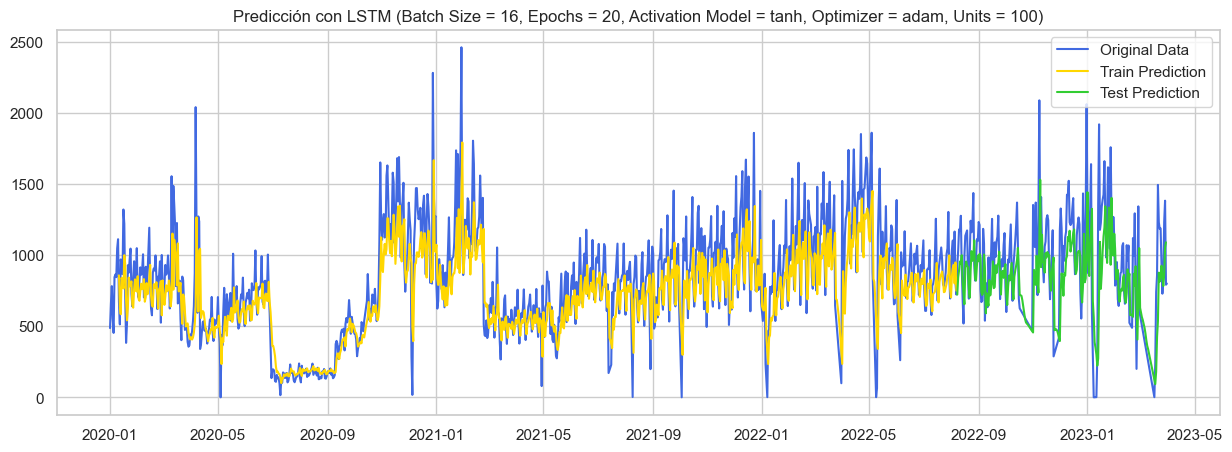

In [94]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_count[['Accident_Count']])

def create_dataset_lstm(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset_lstm(scaled_data, time_step)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

def create_model_lstm(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(model=create_model_lstm, verbose=0)

param_grid = {
    'model__units': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

best_model = grid_result.best_estimator_

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_mae, lstm_mse, lstm_rmse, lstm_r2 = evaluate_forecast(y_test, test_predict)

train_size = int(len(X) * 0.8)

train_index = df_count.index[time_step:train_size + time_step]
test_index = df_count.index[train_size + time_step:train_size + time_step + len(test_predict)]

plt.figure(figsize=(15, 5))
plt.plot(df_count.index, scaler.inverse_transform(scaled_data), label='Original Data', color="royalblue")
plt.plot(train_index, train_predict, label='Train Prediction', color="gold")
plt.plot(test_index, test_predict, label='Test Prediction', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con LSTM (Batch Size = {grid_result.best_params_["batch_size"]}, \
Epochs = {grid_result.best_params_["epochs"]}, \
Activation Model = {grid_result.best_params_["model__activation"]}, \
Optimizer = {grid_result.best_params_["model__optimizer"]}, \
Units = {grid_result.best_params_["model__units"]})')
plt.show()

#### Redes de Kolmogorov-Arnold (KAN)

train loss: 3.16e+02 | test loss: 4.85e+02 | reg: 4.14e+01 : 100%|██| 50/50 [00:21<00:00,  2.36it/s]


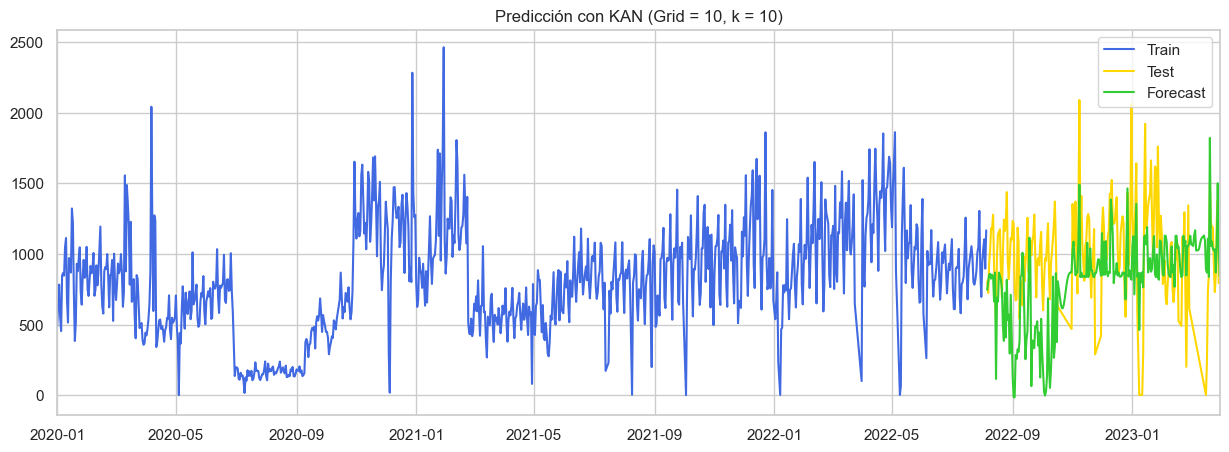

In [73]:
train_size = int(len(df_count) * 0.8)
train, test = df_count.iloc[:train_size], df_count.iloc[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop('Accident_Count', axis=1).values)
y_train = train['Accident_Count'].values.reshape(-1, 1)
X_test = scaler.transform(test.drop('Accident_Count', axis=1).values)
y_test = test['Accident_Count'].values.reshape(-1, 1)

train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.float32)

model = KAN(width=[X_train.shape[1], 1, 1], grid=10, k=10)

dataset = {'train_input': train_input, 'train_label': train_label, \
           'test_input': test_input, 'test_label': test_label}

results = model.train(dataset, opt="LBFGS", steps=50)

predictions = model(test_input).detach().numpy()
actual = y_test

kan_mae, kan_mse, kan_rmse, kan_r2 = evaluate_forecast(actual, predictions)

train_losses = results['train_loss']
test_losses = results['test_loss']

test_dates = test.index
df_forecast = pd.DataFrame({'Actual': actual.flatten(), 'Forecast': predictions.flatten()}, \
                           index=test_dates)

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Accident_Count'], label='Train', color="royalblue")
plt.plot(test.index, test['Accident_Count'], label='Test', color="gold")
plt.plot(test.index, df_forecast['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title('Predicción con KAN (Grid = 10, k = 10)')
plt.margins(x=0)
plt.show()

#### Evaluación de los Modelos

In [74]:
results_count = pd.DataFrame({
    'Model': ['Medias Móviles', 'SARIMAX', 'Prophet', 'LSTM', 'KAN'],
    'MAE': [ma_mae, sarimax_mae, prophet_mae, lstm_mae, kan_mae],
    'MSE': [ma_mse, sarimax_mse, prophet_mse, lstm_mse, kan_mse],
    'RMSE': [ma_rmse, sarimax_rmse, prophet_rmse, lstm_rmse, kan_rmse],
    'R2': [ma_r2, sarimax_r2, prophet_r2, lstm_r2, kan_r2]
})

results_count

,Model,MAE,MSE,RMSE,R2
0,Medias Móviles,302.60,144174.29,379.70,0.04
1,SARIMAX,276.42,137427.11,370.71,0.08
2,Prophet,292.37,144446.74,380.06,0.03
3,LSTM,223.32,87376.36,295.59,0.42
4,KAN,390.29,235615.38,485.40,-0.58


### 4.2. Predicción de Gravedad Media de Accidentes Diarios

In [75]:
df_severity = df.drop('Accident_Count', axis=1)

#### Enfoque Clásico - Método de Medias Móviles

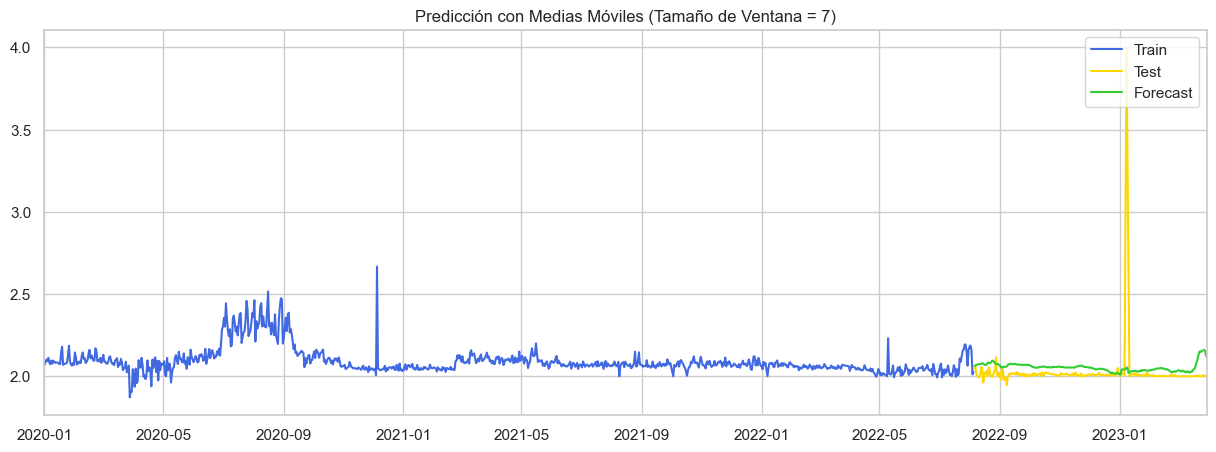

,MAE,MSE,RMSE,R2
Window_Size,,,,
1,0.07,0.03,0.18,-0.09
2,0.07,0.03,0.18,-0.09
3,0.07,0.03,0.18,-0.09
4,0.07,0.03,0.18,-0.09
5,0.07,0.03,0.18,-0.08
6,0.07,0.03,0.18,-0.06
7,0.07,0.03,0.18,-0.05
8,0.07,0.03,0.18,-0.05
9,0.07,0.03,0.18,-0.06


In [76]:
train_size = int(len(df_severity) * 0.8)
train, test = df_severity.iloc[:train_size], df_severity.iloc[train_size:]

best_window_size = None
best_score = float('inf')
metrics_results = []

for window_size in range(1, 21):
    rolling_mean = train['Severity'].rolling(window=window_size).mean()
    forecast = rolling_mean[-len(test):].values
    mae, mse, rmse, r2 = evaluate_forecast(test['Severity'], forecast)
    metrics_results.append((window_size, mae, mse, rmse, r2))
    
    if rmse < best_score:
        best_score = rmse
        best_window_size = window_size

metrics_ma = [metrics for metrics in metrics_results if metrics[0] == best_window_size][0]
ma_mae, ma_mse, ma_rmse, ma_r2 = metrics_ma[1:5]

rolling_mean = train['Severity'].rolling(window=best_window_size).mean()
test = test.copy()
test.loc[:, 'Forecast'] = rolling_mean[-len(test):].values

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Severity'], label='Train', color="royalblue")
plt.plot(test.index, test['Severity'], label='Test', color="gold")
plt.plot(test.index, test['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con Medias Móviles (Tamaño de Ventana = {best_window_size})')
plt.margins(x=0)
plt.show()

metrics_df = pd.DataFrame(metrics_results, columns=['Window_Size', 'MAE', 'MSE', 'RMSE', 'R2'])
metrics_df = metrics_df.set_index('Window_Size')
metrics_df

#### SARIMAX

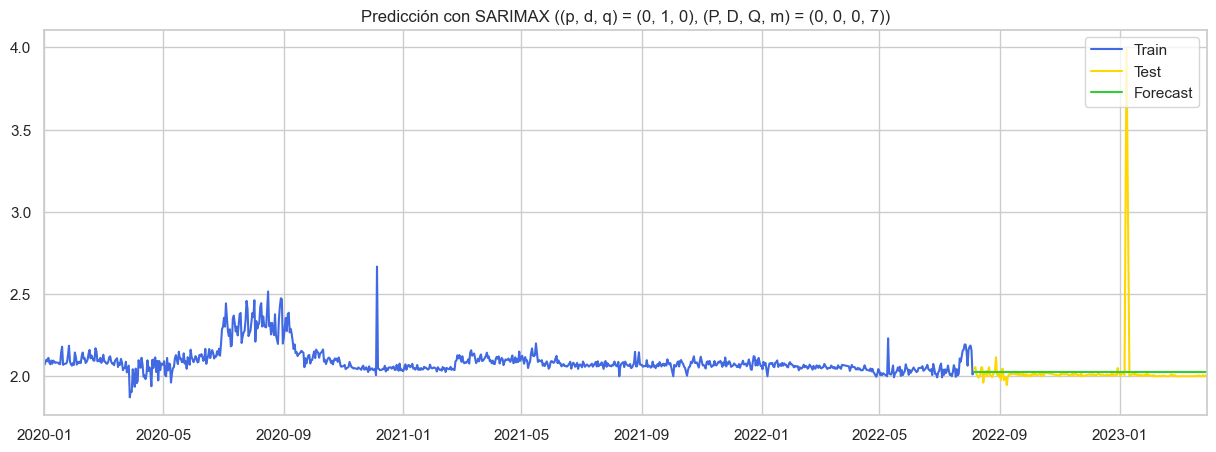

MAE  MSE  RMSE      R2
Order     Seasonal_Order                        
(0, 0, 0) (0, 0, 0, 7)   2.03 4.15  2.04 -138.46
          (0, 0, 1, 7)   2.00 4.06  2.02 -135.48
          (0, 1, 0, 7)   0.12 0.04  0.20   -0.34
          (0, 1, 1, 7)   0.12 0.04  0.19   -0.24
          (1, 0, 0, 7)   0.11 0.04  0.20   -0.29
...                       ...  ...   ...     ...
(2, 2, 2) (0, 1, 1, 7)   0.26 0.09  0.30   -1.93
          (1, 0, 0, 7)   0.05 0.03  0.18   -0.09
          (1, 0, 1, 7)   0.07 0.03  0.19   -0.17
          (1, 1, 0, 7)   0.34 0.14  0.38   -3.87
          (1, 1, 1, 7)   0.12 0.04  0.19   -0.21

[216 rows x 4 columns]

In [77]:
warnings.filterwarnings('ignore')

train_size = int(len(df_severity) * 0.8)
train, test = df_severity.iloc[:train_size], df_severity.iloc[train_size:]

p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = [7]

pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], sp) for x in \
                list(product(seasonal_p, seasonal_d, seasonal_q)) for sp in seasonal_period]

best_score = float('inf')
best_pdq = None
best_seasonal_pdq = None
metrics_results = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train['Severity'], order=param, seasonal_order=param_seasonal, \
                            enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            forecast = results.get_forecast(steps=len(test)).predicted_mean
            mae, mse, rmse, r2 = evaluate_forecast(test['Severity'], forecast)
            metrics_results.append((param, param_seasonal, mae, mse, rmse, r2))
            
            if rmse < best_score:
                best_score = rmse
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

metrics_sarimax = [metrics for metrics in metrics_results \
                   if metrics[0] == best_pdq and metrics[1] == best_seasonal_pdq][0]
sarimax_mae, sarimax_mse, sarimax_rmse, sarimax_r2 = metrics_sarimax[2:6]

best_model = SARIMAX(train['Severity'], order=best_pdq, seasonal_order=best_seasonal_pdq, \
                     enforce_stationarity=False, enforce_invertibility=False)
sarimax_results = best_model.fit(disp=False)
test.loc[:, 'Forecast'] = sarimax_results.get_forecast(steps=len(test)).predicted_mean

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Severity'], label='Train', color="royalblue")
plt.plot(test.index, test['Severity'], label='Test', color="gold")
plt.plot(test.index, test['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con SARIMAX ((p, d, q) = {best_pdq}, (P, D, Q, m) = {best_seasonal_pdq})')
plt.margins(x=0)
plt.show()

metrics_df = pd.DataFrame(metrics_results, columns=['Order', 'Seasonal_Order', 'MAE', 'MSE', 'RMSE', 'R2'])
metrics_df = metrics_df.set_index(['Order', 'Seasonal_Order'])
metrics_df

#### Prophet

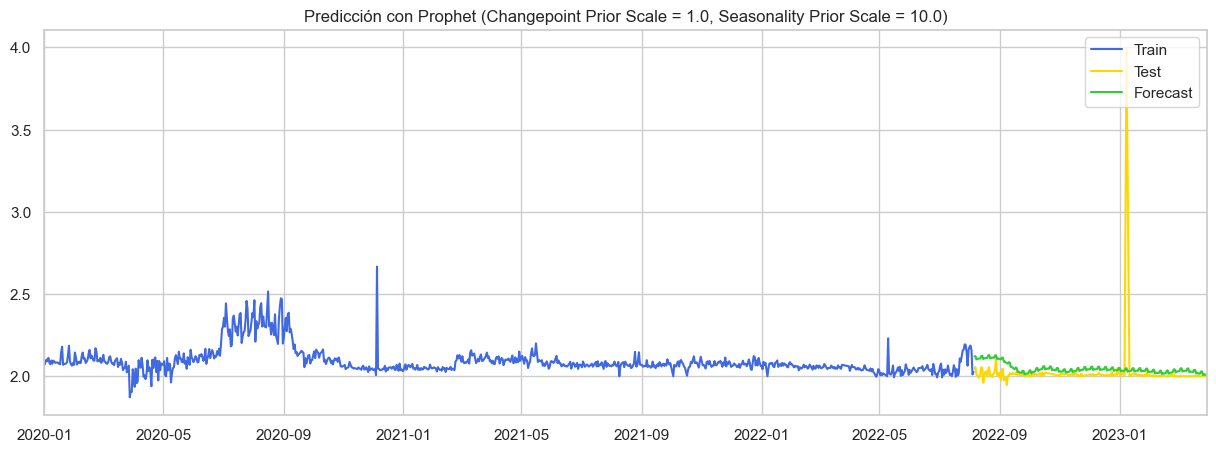

MAE  MSE  RMSE    R2
Changepoint_Prior_Scale Seasonality_Prior_Scale                      
0.01                    0.01                    0.07 0.03  0.19 -0.17
                        0.10                    0.07 0.03  0.19 -0.16
                        1.00                    0.08 0.04  0.19 -0.23
                        10.00                   0.07 0.04  0.19 -0.18
0.10                    0.01                    0.05 0.03  0.18 -0.09
                        0.10                    0.08 0.04  0.19 -0.25
                        1.00                    0.09 0.04  0.20 -0.29
                        10.00                   0.09 0.04  0.20 -0.28
0.50                    0.01                    0.07 0.03  0.18 -0.04
                        0.10                    0.04 0.03  0.18 -0.05
                        1.00                    0.05 0.03  0.18 -0.04
                        10.00                   0.05 0.03  0.18 -0.04
1.00                    0.01                    0.11 0.03  0.18 -0.14
                        0.10                    0.07 0.03  0.18 -0.04
                        1.00                    0.07 0.03  0.18 -0.04
                        10.00                   0.06 0.03  0.18 -0.04

In [78]:
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

df_prophet = df_severity[['Severity']].reset_index()
df_prophet.rename(columns={'Start_Time': 'ds', 'Severity': 'y'}, inplace=True)

train_size = int(len(df_prophet) * 0.8)
train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:].copy()

changepoint_prior_scale_values = [0.01, 0.1, 0.5, 1.0]
seasonality_prior_scale_values = [0.01, 0.1, 1.0, 10.0]

best_score = float('inf')
best_params = None
metrics_results = []

for changepoint_prior_scale in changepoint_prior_scale_values:
    for seasonality_prior_scale in seasonality_prior_scale_values:
        model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale
        )
        model.fit(train)
        
        future = model.make_future_dataframe(periods=len(test))
        forecast = model.predict(future)
        forecast_test = forecast['yhat'][-len(test):].values
        
        mae, mse, rmse, r2 = evaluate_forecast(test['y'], forecast_test)
        metrics_results.append((changepoint_prior_scale, seasonality_prior_scale, mae, mse, rmse, r2))
        
        if rmse < best_score:
            best_score = rmse
            best_params = (changepoint_prior_scale, seasonality_prior_scale)

best_metrics = [metrics for metrics in metrics_results if \
                metrics[0] == best_params[0] and metrics[1] == best_params[1]][0]
prophet_mae, prophet_mse, prophet_rmse, prophet_r2 = best_metrics[2:6]

model = Prophet(
    changepoint_prior_scale=best_params[0],
    seasonality_prior_scale=best_params[1]
)
model.fit(train)
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)
test['Forecast'] = forecast['yhat'][-len(test):].values

plt.figure(figsize=(15, 5))
plt.plot(train['ds'], train['y'], label='Train', color="royalblue")
plt.plot(test['ds'], test['y'], label='Test', color="gold")
plt.plot(test['ds'], test['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con Prophet (Changepoint Prior Scale = {best_params[0]}, Seasonality Prior Scale = {best_params[1]})')
plt.margins(x=0)
plt.show()

metrics_df = pd.DataFrame(metrics_results, columns=['Changepoint_Prior_Scale', 'Seasonality_Prior_Scale', \
                                                    'MAE', 'MSE', 'RMSE', 'R2'])
metrics_df = metrics_df.set_index(['Changepoint_Prior_Scale', 'Seasonality_Prior_Scale'])
metrics_df

#### LSTM

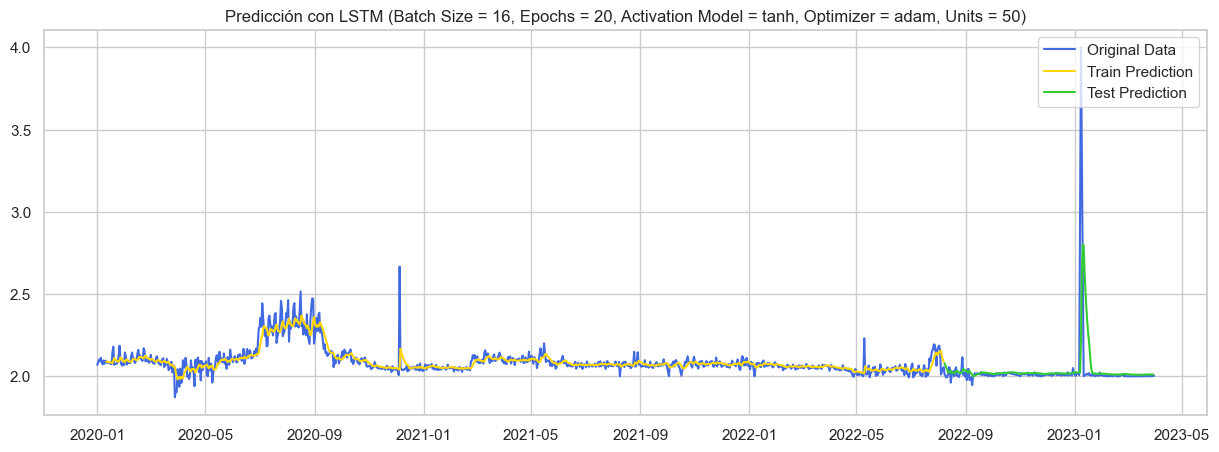

In [79]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_severity[['Severity']])

def create_dataset_lstm(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 10
X, y = create_dataset_lstm(scaled_data, time_step)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

def create_model_lstm(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(model=create_model_lstm, verbose=0)

param_grid = {
    'model__units': [50, 100],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

best_model = grid_result.best_estimator_

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_mae, lstm_mse, lstm_rmse, lstm_r2 = evaluate_forecast(y_test, test_predict)

train_size = int(len(X) * 0.8)

train_index = df_severity.index[time_step:train_size + time_step]
test_index = df_severity.index[train_size + time_step:train_size + time_step + len(test_predict)]

plt.figure(figsize=(15, 5))
plt.plot(df_severity.index, scaler.inverse_transform(scaled_data), label='Original Data', color="royalblue")
plt.plot(train_index, train_predict, label='Train Prediction', color="gold")
plt.plot(test_index, test_predict, label='Test Prediction', color="limegreen")
plt.legend(loc='upper right')
plt.title(f'Predicción con LSTM (Batch Size = {grid_result.best_params_["batch_size"]}, \
Epochs = {grid_result.best_params_["epochs"]}, \
Activation Model = {grid_result.best_params_["model__activation"]}, \
Optimizer = {grid_result.best_params_["model__optimizer"]}, \
Units = {grid_result.best_params_["model__units"]})')
plt.show()

#### Redes de Kolmogorov-Arnold (KAN)

train loss: 6.01e-02 | test loss: 2.08e-01 | reg: 3.73e+00 : 100%|██| 50/50 [00:21<00:00,  2.33it/s]


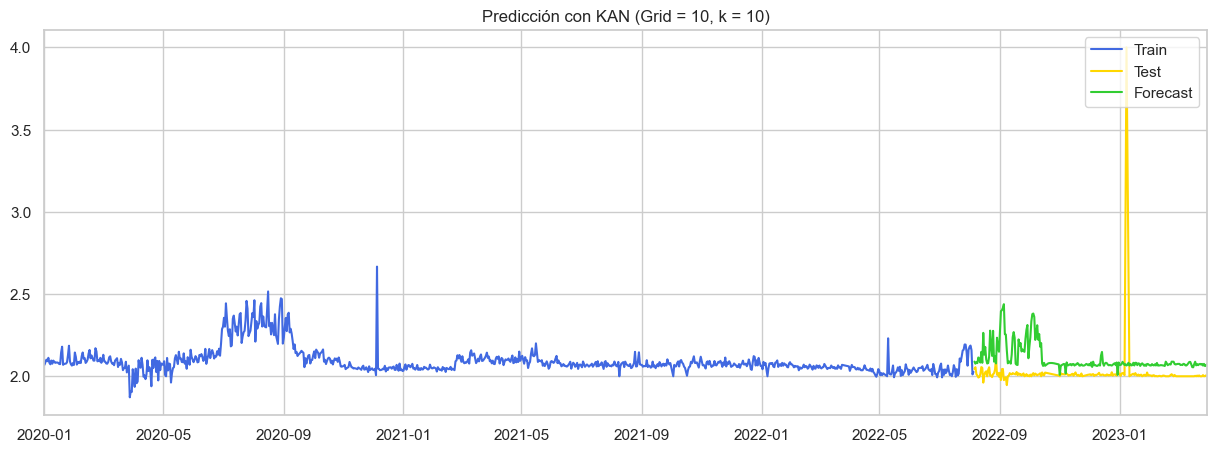

In [80]:
train_size = int(len(df_severity) * 0.8)
train, test = df_severity.iloc[:train_size], df_severity.iloc[train_size:]

scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop('Severity', axis=1).values)
y_train = train['Severity'].values.reshape(-1, 1)
X_test = scaler.transform(test.drop('Severity', axis=1).values)
y_test = test['Severity'].values.reshape(-1, 1)

train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.float32)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.float32)

model = KAN(width=[X_train.shape[1], 1, 1], grid=10, k=10)

dataset = {'train_input': train_input, 'train_label': train_label, 'test_input': test_input, 'test_label': test_label}

results = model.train(dataset, opt="LBFGS", steps=50)

predictions = model(test_input).detach().numpy()
actual = y_test

kan_mae, kan_mse, kan_rmse, kan_r2 = evaluate_forecast(actual, predictions)

train_losses = results['train_loss']
test_losses = results['test_loss']

test_dates = test.index
df_forecast = pd.DataFrame({'Actual': actual.flatten(), 'Forecast': predictions.flatten()}, index=test_dates)

plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Severity'], label='Train', color="royalblue")
plt.plot(test.index, test['Severity'], label='Test', color="gold")
plt.plot(test.index, df_forecast['Forecast'], label='Forecast', color="limegreen")
plt.legend(loc='upper right')
plt.title('Predicción con KAN (Grid = 10, k = 10)')
plt.margins(x=0)
plt.show()

#### Evaluación de los Modelos

In [81]:
results_severity = pd.DataFrame({
    'Model': ['Medias Móviles', 'SARIMAX', 'Prophet', 'LSTM', 'KAN'],
    'MAE': [ma_mae, sarimax_mae, prophet_mae, lstm_mae, kan_mae],
    'MSE': [ma_mse, sarimax_mse, prophet_mse, lstm_mse, kan_mse],
    'RMSE': [ma_rmse, sarimax_rmse, prophet_rmse, lstm_rmse, kan_rmse],
    'R2': [ma_r2, sarimax_r2, prophet_r2, lstm_r2, kan_r2]
})

results_severity

,Model,MAE,MSE,RMSE,R2
0,Medias Móviles,0.07,0.03,0.18,-0.05
1,SARIMAX,0.04,0.03,0.17,-0.00
2,Prophet,0.06,0.03,0.18,-0.04
3,LSTM,0.04,0.03,0.17,0.09
4,KAN,0.12,0.04,0.21,-0.45
